In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



import random
import warnings
from sklearn.metrics import confusion_matrix


#File Operation libraries
import glob
from pathlib import Path

#Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sn


#Keras
from keras.layers import Dense, Conv2D, MaxPooling2D, AvgPool2D, Input, Dropout, Flatten, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19

#Image Transformation Libraries
import cv2


Using TensorFlow backend.
C:\Users\usama\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\usama\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\usama\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\usama\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [3]:
base_dir = "C:/Users/usama/Desktop/COVID_CT/data"
train_dir = base_dir+'/train'
test_dir = base_dir+'/test'
val_dir = base_dir+'/valid'
print(val_dir)

C:/Users/usama/Desktop/COVID_CT/data/valid


In [4]:
def get_df(path):
    lst = []
    normal_dir = Path(path + "/COVID_NO/")
    print(normal_dir)
    pneumonia_dir = Path(path + "/COVID_YES/")
    normal_data = normal_dir.glob("*")
    pneumonia_data = pneumonia_dir.glob("*")
    for fname in normal_data:
        lst.append((fname, 0))
    for fname in pneumonia_data:
        lst.append((fname, 1))
    df = pd.DataFrame(lst, columns=['Image', 'Label'], index=None)
    s = np.arange(df.shape[0])
    np.random.shuffle(s)
    df = df.iloc[s,:].reset_index(drop=True)
    return df

In [5]:
df_train = get_df(train_dir)
df_val = get_df(val_dir)
df_test = get_df(test_dir)


C:\Users\usama\Desktop\COVID_CT\data\train\COVID_NO
C:\Users\usama\Desktop\COVID_CT\data\valid\COVID_NO
C:\Users\usama\Desktop\COVID_CT\data\test\COVID_NO


In [6]:
df_train.shape, df_val.shape, df_test.shape

((546, 2), (60, 2), (140, 2))

In [7]:
df_train['Label'].value_counts()

0    297
1    249
Name: Label, dtype: int64

In [8]:
df_val['Label'].value_counts()

1    30
0    30
Name: Label, dtype: int64

In [9]:
df_test['Label'].value_counts()

1    70
0    70
Name: Label, dtype: int64

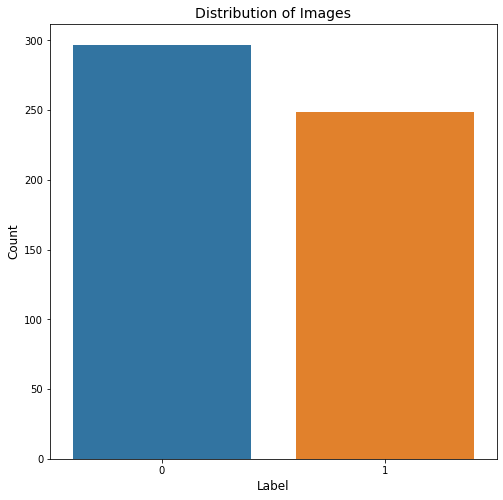

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
sn.countplot(df_train['Label'])
ax.set_title('Distribution of Images', fontsize=14)
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

In [11]:
from imgaug import augmenters as iaa
def transform_image(img_list):
    img = cv2.resize(img_list, (224, 224))
    #cv2 reads image in BGR format. Let's convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img   

def augment_image(img_list):
    seq = iaa.OneOf([
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            rotate=(-25, 25)
        ),
        iaa.Fliplr(),
        iaa.Multiply((1.2, 1.5))
    ])
    return seq.augment_image(img_list)

def transform_augment_batch(img_path_list, label_list, is_augment=False):
    img_list = []
    for i in range(len(img_path_list)):
        img_list.append(transform_image(cv2.imread(str(img_path_list[i]))))
    n = len(img_list)
    if is_augment:
        for i in range(n):
            img = img_list[i]
            img = augment_image(img)
            img_list.append(img)
        img_list = np.array(img_list)
        label_list = np.append(label_list, label_list)
    return img_list, label_list

In [12]:
def generate_batch_images(df, batch_size):
    s = np.arange(df.shape[0])
    np.random.shuffle(s)
    X_dev = np.array(df_train.iloc[s, 0])
    Y_dev = np.array(df_train.iloc[s, 1])
    start_index = 0
    while start_index < len(X_dev):
        if start_index+batch_size <= len(X_dev):
            end_index = start_index+batch_size
        else:
            end_index = len(X_dev)
        #Select image paths in batches
        x_dev = X_dev[start_index:end_index]
        y_dev = Y_dev[start_index:end_index]
        
        #Transform images and augment
        x_dev, y_dev = transform_augment_batch(x_dev, y_dev, True)
        y_dev = y_dev.reshape((len(y_dev), 1))
        
        #Normalize
        x_dev = x_dev / 255.0
        yield x_dev, y_dev

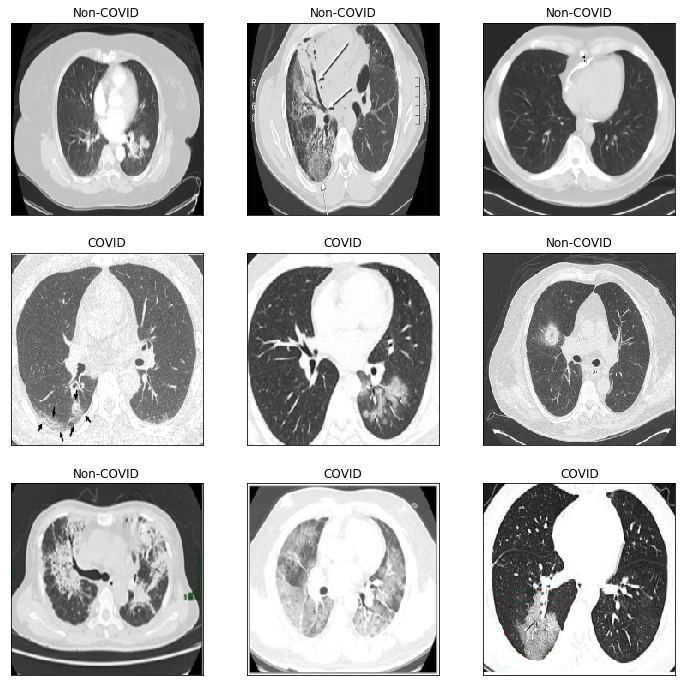

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = transform_image(cv2.imread(str(df_train.iloc[i, 0])))
    plt.imshow(img)
    if df_train.iloc[i, 1] == 0:
        plt.title('Non-COVID')
    else:
        plt.title('COVID')
    plt.xticks([])
    plt.yticks([])
plt.show()

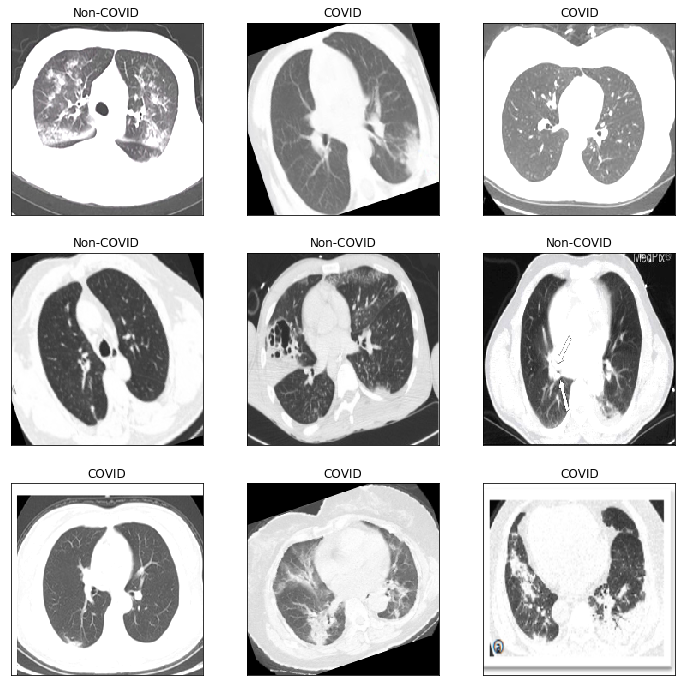

In [62]:
plt.subplots(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = transform_image(cv2.imread(str(df_train.iloc[i, 0])))
    img = augment_image(img)
    plt.imshow(img)
    if df_train.iloc[i, 1] == 0:
        plt.title('Non-COVID')
    else:
        plt.title('COVID')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [14]:
val_labels = np.array(df_val.iloc[:, 1]).reshape((df_val.shape[0], 1))
val_images, _ = transform_augment_batch(df_val.iloc[:, 0], df_val.iloc[:, 1], False)
val_images = np.array(val_images)
val_images = val_images / 255.0

In [15]:
val_images.shape, val_labels.shape

((60, 224, 224, 3), (60, 1))

In [16]:
test_labels = np.array(df_test.iloc[:, 1]).reshape((df_test.shape[0], 1))
test_images, _ = transform_augment_batch(df_test.iloc[:, 0], df_test.iloc[:, 1], False)
test_images = np.array(test_images)
test_images = test_images / 255.0

In [17]:
test_images.shape, test_labels.shape

((140, 224, 224, 3), (140, 1))

In [18]:
base_learning_rate = 1e-5
batch_size=20
epochs = 10

In [19]:
def create_model():
    img_input = Input(shape=(224, 224, 3))

    # Block 1
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv1', trainable=False)(img_input)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv2', trainable=False)(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block1_pool', trainable=False)(x)

    #Block 2
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='block2_conv1',trainable=False)(x)
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='block2_conv2', trainable=False)(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block2_pool', trainable=False)(x)

    #Block 3
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv1',trainable=False)(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv2', trainable=False)(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv3', trainable=False)(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv4', trainable=False)(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block3_pool', trainable=False)(x)

    #Block 4
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv1')(x)
    x = BatchNormalization(name='block4_bn1')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv2')(x)
    x = BatchNormalization(name='block4_bn2')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv3')(x)
    x = BatchNormalization(name='block4_bn3')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv4')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block4_pool')(x)

    #Block 5
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv1')(x)
    x = BatchNormalization(name='block5_bn1')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv2')(x)
    x = BatchNormalization(name='block5_bn2')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv3')(x)
    x = BatchNormalization(name='block5_bn3')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv4')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block5_pool')(x)
    
    #Other layers
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.3, name='dropout_1')(x)
    x = Dense(1000, activation='relu', name='fc2')(x)
    x = Dropout(0.3, name='dropout_2')(x)
    x = Dense(512, activation='relu', name='fc3')(x)
    x = Dropout(0.5, name='dropout_3')(x)
    x = Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = Model(inputs=img_input, outputs=x)
    return model

In [20]:
base_model = VGG19(weights='imagenet', include_top=False)

In [21]:
model = create_model()

In [22]:
layer_count = 0
for layer in model.layers:
    if layer.name[:6] in ['block1', 'block2', 'block3']:
        model.layers[layer_count].set_weights = base_model.layers[layer_count].get_weights()
    layer_count += 1

In [23]:
adam = Adam(lr = base_learning_rate)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-7)

In [25]:
model_chkpoint = ModelCheckpoint(filepath='vgg_19_best_model', save_best_only=True, save_weights_only=True)

In [26]:
data_generator = generate_batch_images(df_train, batch_size)

In [27]:
model.fit_generator(data_generator, epochs=epochs, steps_per_epoch=df_train.shape[0]/batch_size, 
                    callbacks=[reduce_lr, model_chkpoint], validation_data=[val_images, val_labels],
                    class_weight={0:3, 1:1})


Epoch 1/10
28/27 [==============================] - 1559s 56s/step - loss: 0.7483 - accuracy: 0.7750 - val_loss: 0.6932 - val_accuracy: 0.5000


C:\Users\usama\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/10
28/27 [==============================] - 615s 22s/step - loss: 0.2549 - accuracy: 0.9250 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 3/10
28/27 [==============================] - 583s 21s/step - loss: 0.1529 - accuracy: 0.9607 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 4/10
28/27 [==============================] - 574s 20s/step - loss: 0.1099 - accuracy: 0.9670 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/10
28/27 [==============================] - 1103s 39s/step - loss: 0.1427 - accuracy: 0.9652 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 6/10
28/27 [==============================] - 1119s 40s/step - loss: 0.0963 - accuracy: 0.9723 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 7/10
28/27 [==============================] - 822s 29s/step - loss: 0.1104 - accuracy: 0.9688 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 8/10
28/27 [==============================] - 685s 24s/step - loss: 0.0778 - accuracy: 0.9804 - val_loss: 0.7023 - val_accuracy: 0.5000
Epoc

In [28]:
test_logits = model.predict(test_images, batch_size=16)

In [29]:
test_loss, test_acc = model.evaluate(test_images, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_acc)

140/140 [==============================] - 22s 155ms/step
Loss on test set:  0.7539872901780265
Accuracy on test set:  0.5


In [34]:
from mlxtend.plotting import plot_confusion_matrix

<Figure size 432x288 with 0 Axes>

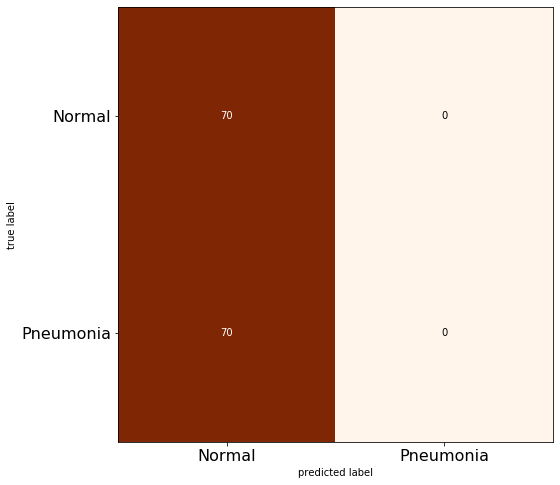

In [35]:
cm  = confusion_matrix(test_labels, np.round(test_logits))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Oranges)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [36]:
true_negative, false_positive, false_negative, true_positive  = cm.ravel()
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print('Precison of chest X-ray for pneumonia:{:.2f}'.format(precision))
print('Recall of chest X-ray for pneumonia:{:.2f}'.format(recall))

Precison of chest X-ray for pneumonia:nan
Recall of chest X-ray for pneumonia:0.00


C:\Users\usama\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in longlong_scalars
  
